In [1]:
# Core
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn — data handling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

# Scikit-learn — model and evaluation
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.metrics import roc_curve, auc, precision_recall_curve


In [2]:
def load_images_from_folder(folder_label_pairs, image_size=None):
    data = []

    for folder, label in folder_label_pairs:
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder, filename)
                img = Image.open(img_path).convert('RGB')

                if image_size:
                    img = img.resize(image_size)

                img_array = np.array(img).flatten()
                data.append({
                    'flattened_pixels': img_array,
                    'label': label
                })

    df = pd.DataFrame(data)
    return df

In [3]:
class1_folder = r"E:\POC_Jain_Irrigation\data\A\train_cropped"
class2_folder = r"E:\POC_Jain_Irrigation\data\B\train_cropped"
class3_folder = r"E:\POC_Jain_Irrigation\data\C\train_cropped"
class4_folder = r"E:\POC_Jain_Irrigation\data\D\train_cropped"

In [4]:
folders = [
    (class1_folder, 1),
    (class2_folder, 2),
    (class3_folder, 3),
    (class4_folder, 4)
]

In [5]:
widths, heights = [], []

for folder, label in folders:
    print(f"\nChecking folder: {folder} (class {label})")
    for filename in tqdm(os.listdir(folder)):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        path = os.path.join(folder, filename)
        try:
            with Image.open(path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except Exception as e:
            print(f"⚠️ Skipped {filename}: {e}")

widths, heights = np.array(widths), np.array(heights)

print("\n===== IMAGE SIZE SUMMARY =====")
print(f"Total images: {len(widths)}")
print(f"Width  → min: {widths.min()}, max: {widths.max()}, mean: {widths.mean():.1f}")
print(f"Height → min: {heights.min()}, max: {heights.max()}, mean: {heights.mean():.1f}")


Checking folder: E:\POC_Jain_Irrigation\data\A\train_cropped (class 1)


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 7416.50it/s]



Checking folder: E:\POC_Jain_Irrigation\data\B\train_cropped (class 2)


100%|████████████████████████████████████████████████████████████████████████████████| 82/82 [00:00<00:00, 7733.17it/s]



Checking folder: E:\POC_Jain_Irrigation\data\C\train_cropped (class 3)


100%|███████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 11301.39it/s]



Checking folder: E:\POC_Jain_Irrigation\data\D\train_cropped (class 4)


100%|███████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 13281.79it/s]


===== IMAGE SIZE SUMMARY =====
Total images: 332
Width  → min: 644, max: 3000, mean: 877.7
Height → min: 698, max: 3412, mean: 897.3


In [6]:
def load_images_with_padding(folder_label_pairs, image_size=(512,512), pad_color=(255,255,255)):
    """
    Loads all images from the given folders, resizes while preserving aspect ratio,
    and pads them with a neutral color to make them uniform-sized.
    
    Parameters
    ----------
    folder_label_pairs : list of (folder_path, label)
        Folders and corresponding labels.
    image_size : tuple (width, height)
        Target final image size after padding.
    pad_color : tuple (R,G,B)
        Color used for padding (default white).
    
    Returns
    -------
    pd.DataFrame with 'flattened_pixels' and 'label' columns.
    """
    data = []

    for folder, label in folder_label_pairs:
        image_files = [f for f in os.listdir(folder)
                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for filename in tqdm(image_files, desc=f"Processing {os.path.basename(folder)}"):
            path = os.path.join(folder, filename)
            try:
                img = Image.open(path).convert("RGB")

                # Preserve aspect ratio
                img.thumbnail(image_size, Image.Resampling.LANCZOS)

                # Create white background
                background = Image.new("RGB", image_size, pad_color)
                offset = (
                    (image_size[0] - img.width) // 2,
                    (image_size[1] - img.height) // 2
                )
                background.paste(img, offset)

                img_array = np.array(background) / 255.0   # normalize
                flat = img_array.flatten()

                data.append({
                    'flattened_pixels': flat,
                    'label': label
                })
            except Exception as e:
                print(f"⚠️ Skipped {filename}: {e}")

    df = pd.DataFrame(data)
    return df

In [7]:
df = load_images_with_padding(folders)
print(df.head())
print(df.shape)

Processing train_cropped: 100%|████████████████████████████████████████████████████████| 92/92 [00:01<00:00, 63.04it/s]

                                    flattened_pixels  label
0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
3  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
4  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...      1
(332, 2)


In [8]:
arr = df.iloc[1, 0]
print("Min:", arr.min())
print("Max:", arr.max())

Min: 0.0
Max: 1.0


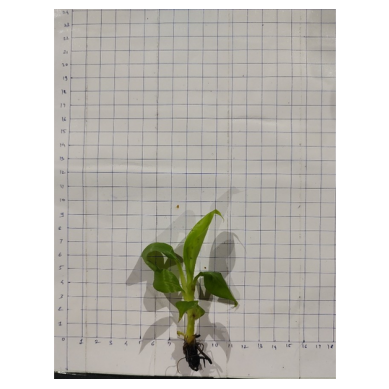

In [9]:
img = arr.reshape(512, 512, 3)  # use your image_size used in preprocessing

import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
X = np.stack(df['flattened_pixels'].values)
y = df['label'].values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (332, 786432)
y shape: (332,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
svm_model = LinearSVC(
    penalty='l2',         
    loss='squared_hinge', 
    dual=False,          
    max_iter=2000,        
    tol=1e-4,         
    verbose=1           
)

svm_model.fit(X_train, y_train)

[LibLinear]

,penalty,'l2'
,loss,'squared_hinge'
,dual,False
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,1
,random_state,None


In [13]:
import joblib

joblib.dump(svm_model, "svm_model.pkl")

['svm_model.pkl']

In [14]:
y_pred = svm_model.predict(X_test)
y_pred_test = svm_model.predict(X_train)
# --- Accuracy ---
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print(classification_report(y_train, y_pred_test))

✅ Accuracy: 0.791

Classification Report:

              precision    recall  f1-score   support

           1       0.83      0.88      0.86        17
           2       0.79      0.69      0.73        16
           3       0.83      0.67      0.74        15
           4       0.74      0.89      0.81        19

    accuracy                           0.79        67
   macro avg       0.80      0.78      0.79        67
weighted avg       0.80      0.79      0.79        67

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        65
           2       1.00      1.00      1.00        66
           3       1.00      1.00      1.00        61
           4       1.00      1.00      1.00        73

    accuracy                           1.00       265
   macro avg       1.00      1.00      1.00       265
weighted avg       1.00      1.00      1.00       265



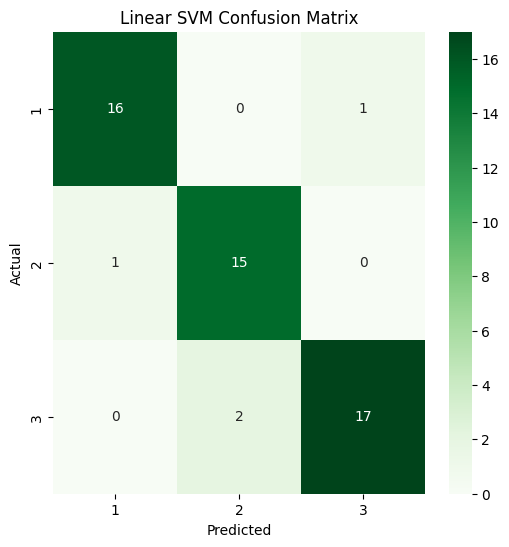

In [36]:
cm = confusion_matrix(y_test, y_pred)
labels = sorted(np.unique(y_test))

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Linear SVM Confusion Matrix")
plt.show()


In [37]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm_model, X, y, cv=cv, scoring='accuracy')

print(f"Cross-validation accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Cross-validation accuracy: 0.906 ± 0.044


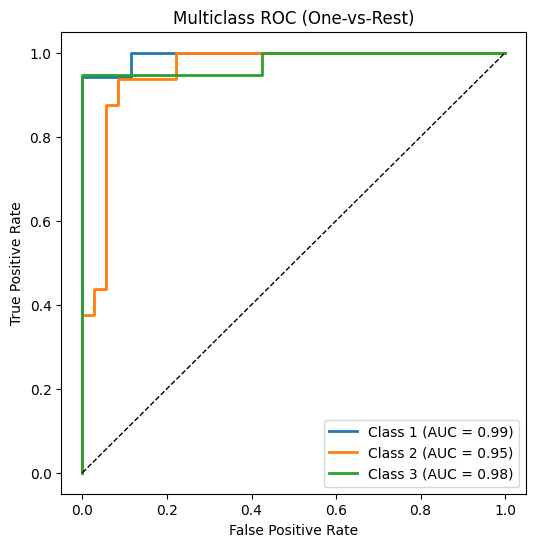

In [38]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convert y_test to one-hot encoded format
y_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_bin.shape[1]

# Decision function scores
y_score = svm_model.decision_function(X_test)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(6, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()